In [2]:
import os
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [4]:
# Model 1
class MNISTModel1(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 10)

    def latent_representation(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        return x

    def forward(self, x):
        x = self.latent_representation(x)
        x = self.fc3(x)
        return x

In [5]:
# Model 2
class MNISTModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        self.classifier = nn.Linear(128, 10)

    def latent_representation(self, x):
        return self.feature_extractor(x)

    def forward(self, x):
        x = self.latent_representation(x)
        x = self.classifier(x)
        return x

In [6]:
# Model 3
class MNISTModel3(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.classifier = nn.Linear(128, 10)

    def latent_representation(self, x):
        return self.feature_extractor(x)

    def forward(self, x):
        x = self.latent_representation(x)
        x = self.classifier(x)
        return x

In [7]:
# Load MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5,), (0.5,))]
)

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=4, shuffle=False)

In [16]:
model = MNISTModel3().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
for epoch in range(10):
    model.train(True)
    for batch_idx, data in enumerate(train_loader):

        inputs, labels = data

        optimizer.zero_grad()

        output = model(inputs)

        loss = loss_fn(output, labels)
        loss.backward()

        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.14148764312267303
Epoch 2, Loss: 1.526257038116455
Epoch 3, Loss: 0.23311400413513184
Epoch 4, Loss: 0.02600378543138504
Epoch 5, Loss: 0.06915570795536041
Epoch 6, Loss: 0.04385531321167946
Epoch 7, Loss: 0.18527840077877045
Epoch 8, Loss: 0.17164507508277893
Epoch 9, Loss: 0.056539006531238556
Epoch 10, Loss: 0.19111575186252594


In [ ]:
# Evaluate the model (Training Accuracy)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in train_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Training Accuracy: {100 * correct / total}%')

Training Accuracy: 96.08333333333333%


In [ ]:
# Evaluate the model (Testing Accuracy)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f'Test Accuracy: {100 * correct / total}%')

Test Accuracy: 95.14%


In [17]:
torch.save(model.state_dict(), 'model3_latent.pth')

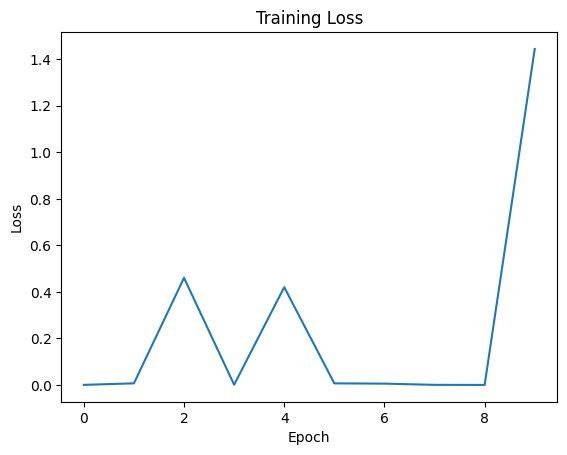

In [12]:
# Model 1
training_loss = [0.2578650712966919, 7.166615978349e-05, 0.06458990275859833, 0.002154930494725704, 0.01413679774850607, 0.0007039917400106788, 0.001981335459277034, 0.010870570316910744, 0.8318904638290405, 1.1233336925506592]
training_loss_latent = [0.0005112922517582774, 0.00706838071346283, 0.4603545069694519, 0.0011685453355312347, 0.42020466923713684, 0.0069748470559716225, 0.005807740148156881, 0.0005681610200554132, 0.00026278907898813486, 1.4441938400268555]

# Plot training loss vs epoch
import matplotlib.pyplot as plt
plt.plot(training_loss_latent)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

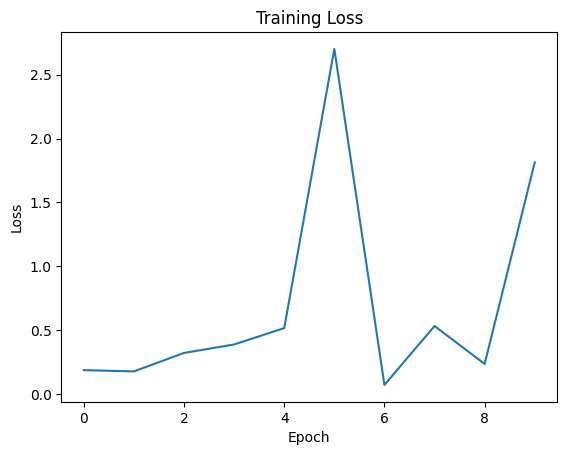

In [13]:
# Model 2
training_loss = [1.5753722190856934, 1.0207328796386719, 1.079522728919983, 0.5205684900283813, 0.810179591178894, 0.6023236513137817, 0.01881249248981476, 0.3732471466064453, 0.012271569110453129, 1.7936770915985107]
training_loss_latent = [0.18724338710308075, 0.1774914562702179, 0.32201194763183594, 0.38823050260543823, 0.516462504863739, 2.702056646347046, 0.07162222266197205, 0.5326589345932007, 0.23592492938041687, 1.813162088394165]

# Plot training loss vs epoch
plt.plot(training_loss_latent)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

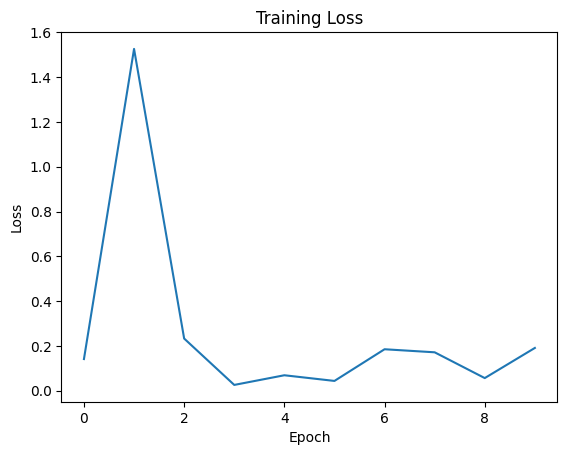

In [20]:
# Model 3
training_loss = [0.8719089031219482, 0.37131258845329285, 0.09651294350624084, 0.026410367339849472, 1.8129433393478394, 0.11489345878362656, 0.1973603367805481, 1.7633391618728638, 5.031050205230713, 0.1530427187681198]
training_loss_latent = [0.14148764312267303, 1.526257038116455, 0.23311400413513184, 0.02600378543138504, 0.06915570795536041, 0.04385531321167946, 0.18527840077877045, 0.17164507508277893, 0.056539006531238556, 0.19111575186252594]

# Plot training loss vs epoch
plt.plot(training_loss_latent)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

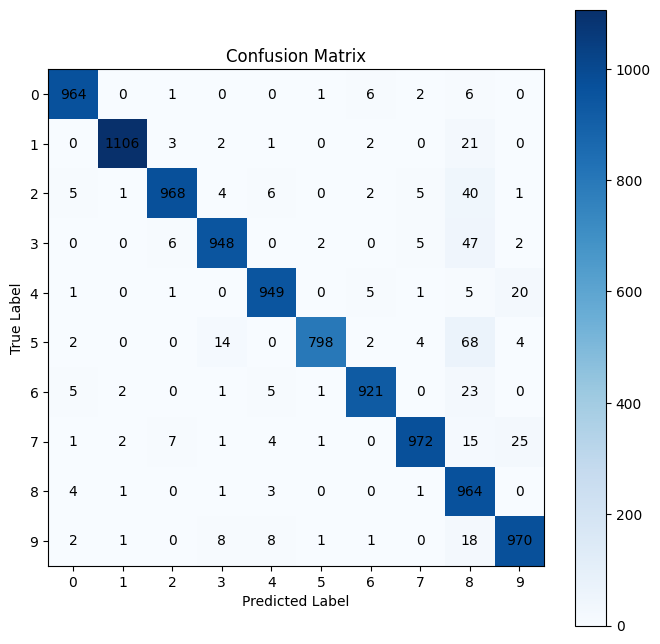

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

model.eval()

y_pred = []
y_true = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(target.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(np.arange(10), labels=np.arange(10))
plt.yticks(np.arange(10), labels=np.arange(10))

for i in range(10):
    for j in range(10):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.show()